# DETR

## Model Overview
https://arxiv.org/pdf/2005.12872.pdf

Interesting features:
- Uses "bipartite matching" which replaces traditional regional-proposal heuristics (e.g. R-CNN)
- Encoder self-attention with positional encoding seems to be able to separate instances of objects (e.g. pg.11, Fig.3)
- Decoder seems to learn "extremity" features like ears, feet, and tails on animals (e.g. pg. 13, Fig.6)
- Has fixed `N` object queries which learn to observe certain regions of the image.  Given `N` queries, performance drops off significantly if there are more than `N/2` objects in the image.

![DETR](https://miro.medium.com/max/967/1*ROEemTct0f47Y2kDlAAF4Q.png)

In [ ]:
from collections import defaultdict
from io import BytesIO

import httpx
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
from torchvision.models import resnet50


## Use Pretrained Model

Default to using DETR with ResNet101 backbone

In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)

Using cache found in /home/andrew/.cache/torch/hub/facebookresearch_detr_master


These are the standard categories from the COCO dataset, taken here:

https://github.com/nightrome/cocostuff/blob/master/labels.md

In [ ]:
categories = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [ ]:
def create_img(url, dims=(800,600)):
    r = httpx.get(url)
    return Image.open(BytesIO(r.content)).resize(dims)

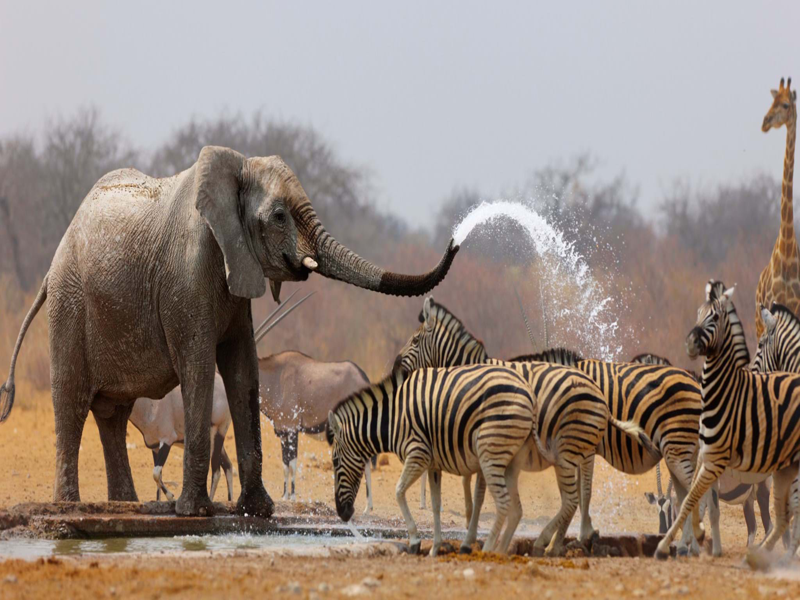

In [ ]:
img = create_img('https://yellowzebrasafaris.com/media/20421/shutterstock_56118346.jpg?anchor=center&mode=crop&width=2048&height=1024&format=jpg&rnd=131565353830000000')
img

## Normalize data

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize(*imagenet_stats)
])

transformed = transform(img)

## Batchify Image for Model

Model requires 4d tensor input `B * W * H * C`, so we create a `B` dimension of 1

In [ ]:
transformed = transformed.unsqueeze(0)

In [ ]:
with torch.no_grad():
    preds = model(transformed)

In [ ]:
preds['pred_logits'].shape, preds['pred_boxes'].shape

(torch.Size([1, 100, 92]), torch.Size([1, 100, 4]))

## Annotate Image

This is just used to more easily differentiate bounding boxes

In [ ]:
colours = defaultdict(
    lambda: "#f5f6fa",
    {
        "giraffe": "#EE5A24",
        "zebra": "#A3CB38",
        "elephant": "#5f27cd",
        "dog": "#EA2027",
        "cat": "#0652DD",
        "bird": "#009432",
    },
)

In [ ]:
def _annotate_img(img, label, prob, bb):
    x, y, w, h = bb
    x0, x1 = x - w // 2, x + w // 2
    y0, y1 = y - h // 2, y + h // 2

    colour = colours[label]

    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('JetBrainsMono-Regular.ttf', 30)
    draw.rectangle([x0, y0, x1, y1], width=5, outline=colour)
    draw.text((x0+5, y0-35), f'{label}: {prob:.3}', fill=colour, font=font)

    return img


def annotate_img(img, logits, bb):
    for l, bb in zip(logits, bb):
        category = l.argmax()
        odds = l.max().exp()
        prob = odds / (1+odds)
        if category < len(categories):
            label = categories[category]
            scaled_bb = bb * torch.Tensor([*img.size, *img.size])
            img = _annotate_img(img, label, prob, scaled_bb)

    return img

Seems like there are some cases where we get double bounding boxes (giraffe, zebra)

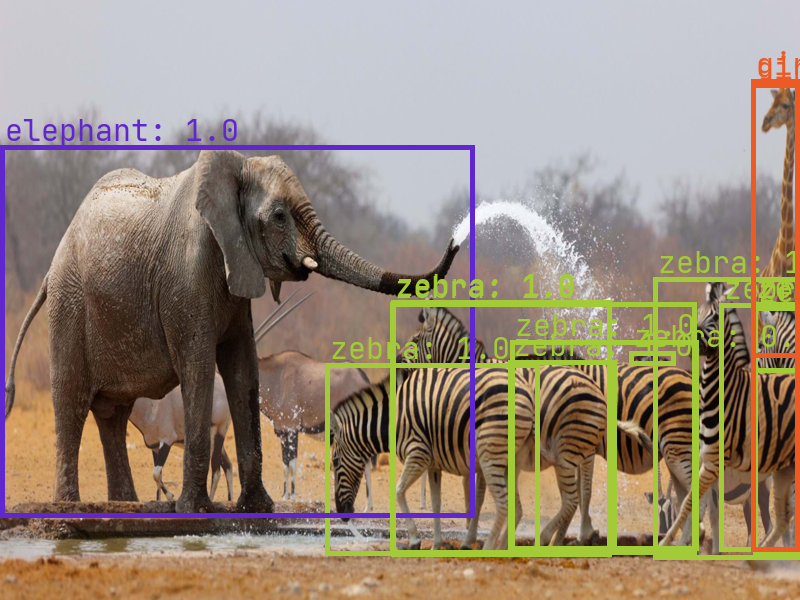

In [ ]:
annotate_img(img, preds['pred_logits'][0], preds['pred_boxes'][0])

## End-to-End


In [ ]:
def url2preds(url: str) -> Image:
    img = create_img(url)
    transformed = transform(img).unsqueeze(0)

    with torch.no_grad():
        preds = model(transformed)

    annotated_img = annotate_img(img, preds['pred_logits'][0], preds['pred_boxes'][0])

    return annotated_img

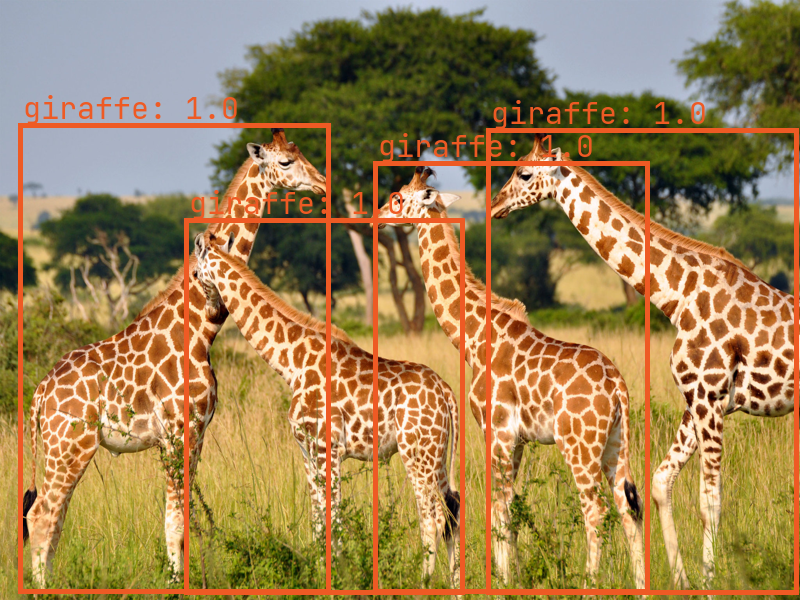

In [ ]:
url2preds('https://static01.nyt.com/images/2014/10/07/science/07JPGIRA1/07JPGIRA1-superJumbo.jpg')

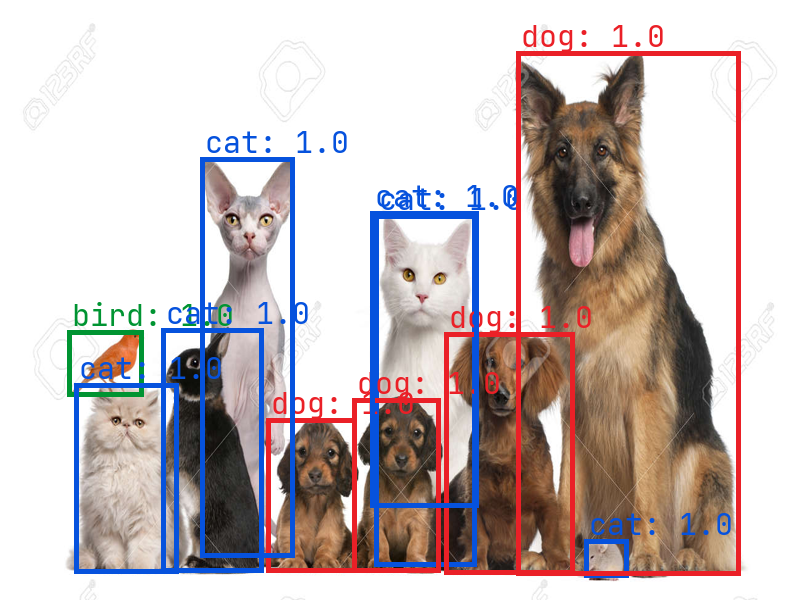

In [ ]:
url2preds('https://previews.123rf.com/images/isselee/isselee1205/isselee120500007/13590258-group-of-pets-dog-cat-bird-rabbit.jpg')

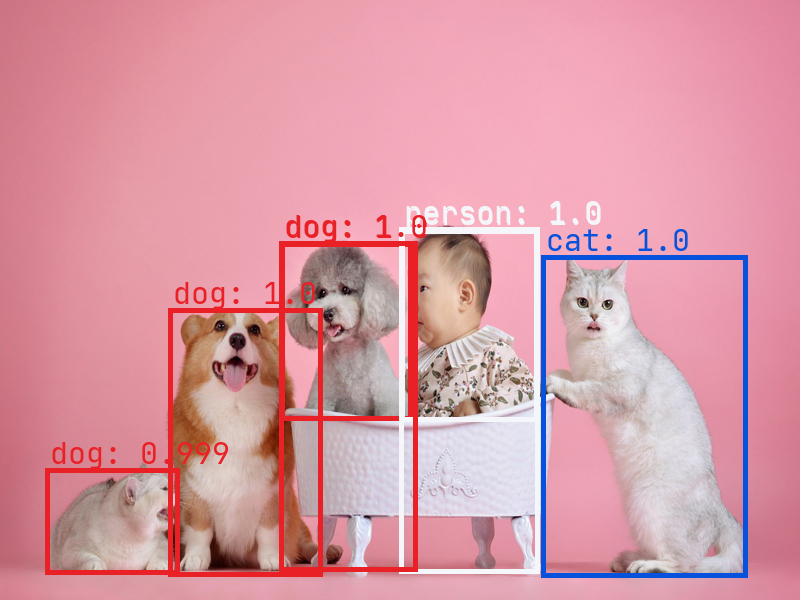

In [ ]:

url2preds('https://img5.goodfon.com/wallpaper/nbig/d/33/koshki-sobaki-rozovyi-fon-druzia-kompaniia-kot-koshka-soba-2.jpg')

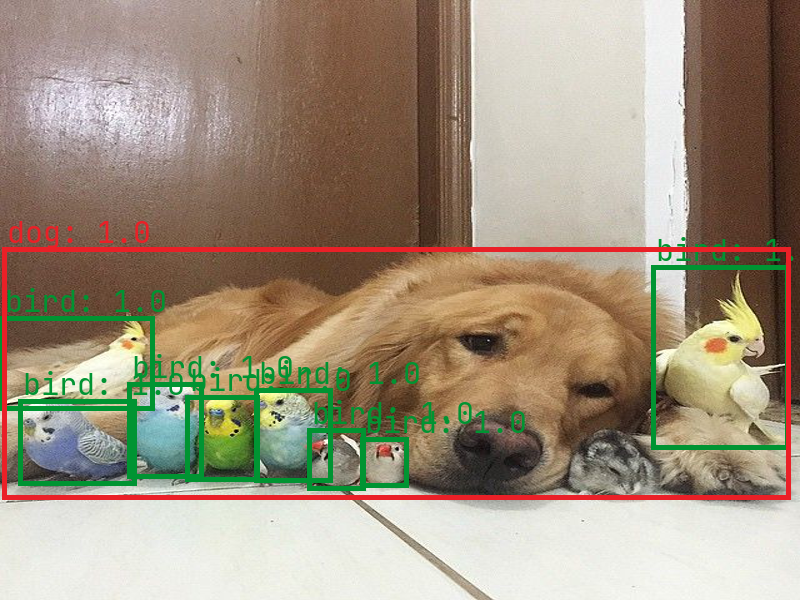

In [ ]:
url2preds('https://i.pinimg.com/originals/b3/bc/bc/b3bcbc4449d458db944deb6debb7e669.jpg')

In [ ]:
#hide

#model from scratch
class DETR(nn.Module):
    def __init__(self,
                 num_classes,                                                 # FC params
                 hidden_dims, nheads, num_encoder_layers, num_decoder_layers  # transformer params
                 ):
        super().__init__()

        self.backbone = resnet50()

        # adapt backbone for encoder
        # del self.backbone.fc
        self.backbone.fc = nn.Conv2d(2048, hidden_dims, 1)
        # self.backbone2transformer = nn.Conv2d(2048, hidden_dims, 1)

        self.transformer = nn.Transformer(hidden_dims, nheads, num_encoder_layers, num_decoder_layers)

        self.linear_category = nn.Linear(hidden_dims, num_classes+1)  # +1 for null class
        self.linear_bb = nn.Linear(hidden_dims, 4)                    #  1 for each corner


        # For encoder
        self.row_embeddings = nn.Parameter(torch.rand(50, hidden_dims//2))
        self.col_embeddings = nn.Parameter(torch.rand(50, hidden_dims//2))

        # For decoder (obj query)
        self.obj_queries = nn.Parameter(torch.rand(50, hidden_dims))

    def forward(self, x):
        x = self.backbone(x)
        # x = self.backbone2transformer(x)

        H, W = x.shape[-2:]
        # Why is this the positional encoding?
        pos = torch.cat([
            self.col_embeddings[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embeddings[:H].unsqueeze(1).repeat(1, W, 1)
        ], dim=-1).flatten(0,1).unsqueeze((1))

        x = self.transformer(pos + 0.1 * x.flatten(2).permute(2,0,1), self.obj_queries.unsqueeze(1)).transpose(0,1)

        return {'logits': self.linear_category(x), 'bb': self.linear_bb(x).sigmoid()}